## Scanpy clustering analysis redone on Mouse Brain (3k genes) dataset:

In this notebook I am going to follow the main analysis steps of the tutorial notebook in the scanpy webpage (Clustering 3K PBMCs) which itself is following Seurat - Guided Clustering Tutorial.

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import loompy

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80)

scanpy==1.4.3 anndata==0.6.21 umap==0.3.9 numpy==1.16.0 scipy==1.2.1 pandas==0.24.2 scikit-learn==0.20.3 statsmodels==0.10.0 python-igraph==0.7.1 louvain==0.6.1 


The data I am using was downloaded from http://scope.aertslab.org.

In [2]:
filename ="Linnarsson_Mouse_Brain_3k.loom"
adata = sc.read_loom(filename, sparse=True, cleanup=False, X_name='spliced', obs_names='CellID', var_names='Gene', dtype='float32', validate=False)

In [3]:
adata.var_names_make_unique()

In [4]:
len(set(adata.var_names))

19970

## Preprocessing

Following will be done in this section: 
    * selection and filtration of cells based on quality control metrics, 
    * data normalization and scaling
    * the detection of highly variable features.

Let's start with exploring the data by viewing top 20 of the highly expressed genes. 

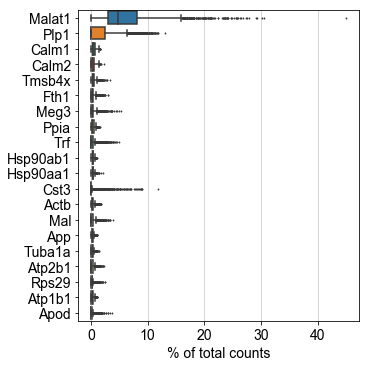

In [5]:
sc.pl.highest_expr_genes(adata, n_top=20)

As you can observe the most expressed gene in this mouse brain dataset is the same gene as in the human dataset. This gene is non-protein coding and it exists both humans and mice. 

In the preprocessing step the aim is to remove the recorded data which are not viable according to the quality control metrics:

   * cells that have few gene counts --> low-quality cells or empty droplets 
   * cells with abnormally high gene counts --> cell doublets or multiplets 
   
Here we filter the genes which has less than 200 genes expressed and genes which are not expressed in more than 3 cells.

In [6]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 1093 genes that are detected in less than 3 cells


In the original analysis they remove the gene expression data that are coming from mitochondrial expression. Here I check if I have the same problem: 

In [7]:
set(adata.var_names.str.startswith('MT-'))

{False}

I don't have the mitochondrial dna (at least the ones which follows the naming convention as above), I will continue with calculating the overall rna expression counts for each genes.

In [8]:
adata.obs['n_counts'] = adata.X.sum(axis=1).A1
adata.obs['n_counts'].head(5)

1772071015_C02    21580.0
1772071017_G12    21747.0
1772071017_A05    31640.0
1772071014_B06    32914.0
1772067065_H06    21528.0
Name: n_counts, dtype: float32

Here I check the summary statistics with violin plot, for number of unique genes and their expression counts.

... storing 'CellType' as categorical
... storing 'Regulons' as categorical


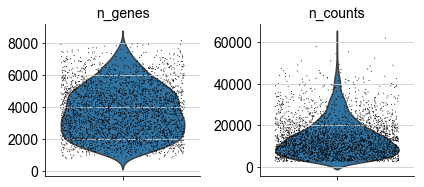

In [9]:
sc.pl.violin(adata, ['n_genes','n_counts'], jitter=0.4, multi_panel=True)

One can observe from the violin plots that although the count numbers don't change too much (localized around 10k) however expressed number of genes has more variability. 

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scanpy/plotting/_anndata.py:311: DeprecationWarning: Use obs_vector instead of _get_obs_array, _get_obs_array will be removed in the future.
  x_arr = adata._get_obs_array(x, use_raw=use_raw, layer=layers[0])
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/anndata/base.py:1618: FutureWarning: In a future version of AnnData, access to `.X` by passing `layer='X'` will be removed. Instead pass `layer=None`.
  FutureWarning
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scanpy/plotting/_anndata.py:312: DeprecationWarning: Use obs_vector instead of _get_obs_array, _get_obs_array will be removed in the future.
  y_arr = adata._get_obs_array(y, use_raw=use_raw, layer=layers[1])
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/anndata/base.py:1618: FutureWarning: In a future version of AnnData, access to `.X` by passing `layer='

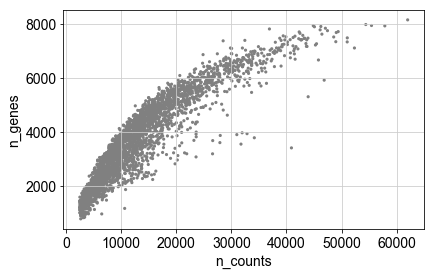

In [10]:
sc.pl.scatter(adata, x='n_counts', y='n_genes') 

Scatter plot tells more or less the same story with the violin plots. 

In [11]:
adata

AnnData object with n_obs × n_vars = 3005 × 18877 
    obs: 'CellType', 'Embedding', 'Embeddings_X', 'Embeddings_Y', 'RegulonsAUC', 'nGene', 'nUMI', 'n_genes', 'n_counts'
    var: 'Regulons', 'n_cells'

Here by checking the annotated data we can observe that the n_count is added to the observations. 

As mentioned earlier another indicator of faulty data is high number of different gene count from a cell. From the violin plot corresponding to the n_gene we can say that deviation of the reads is high and there is not a long tail like in the original example, but for the sake of demonstration I will cut the small tail of the distribution and deem any read above 8k as faulty.

In [12]:
adata = adata[adata.obs['n_genes'] < 8000, :]

In [13]:
adata

View of AnnData object with n_obs × n_vars = 3004 × 18877 
    obs: 'CellType', 'Embedding', 'Embeddings_X', 'Embeddings_Y', 'RegulonsAUC', 'nGene', 'nUMI', 'n_genes', 'n_counts'
    var: 'Regulons', 'n_cells'

After filtering, we reach the final form of the dataset. And now it is time to normalize the data. I followed the defaults of normalization as the pbmc example.

In [14]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)

Trying to set attribute `.obs` of view, making a copy.


In [15]:
sc.pp.log1p(adata)

For differential testing and visualizations of gene expression logarithmized raw gene expression will be saved as raw data. (We will later filter the dataset to highly variable genes)

In [16]:
adata.raw = adata

In [18]:
adata

AnnData object with n_obs × n_vars = 3004 × 18877 
    obs: 'CellType', 'Embedding', 'Embeddings_X', 'Embeddings_Y', 'RegulonsAUC', 'nGene', 'nUMI', 'n_genes', 'n_counts'
    var: 'Regulons', 'n_cells'

Through the preprocessing methods (pp) one can calculate the highly variable genes. The genes which are highly expressed 
in some cells and lowly expressed in others.

In [19]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


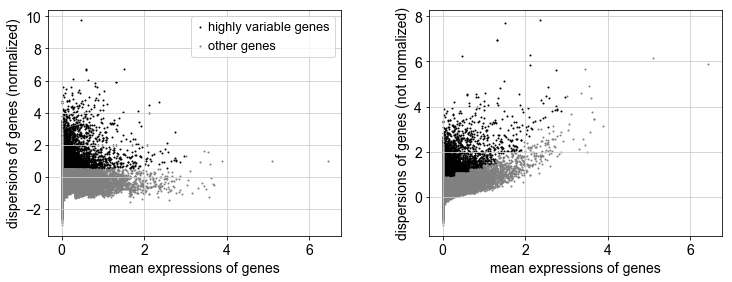

In [20]:
sc.pl.highly_variable_genes(adata)

Now we will filter the dataset to the highly variable genes.

In [21]:
adata = adata[:, adata.var['highly_variable']]

Next, linear transformations will be applied to the data so that pca can be applied. 
Regress_out will adjust for n_counts, and scale scales the expression of each gene to variance across cells as 1.
This step is to give equal weights in downstream analyses, so that highly-expressed genes do not dominate.

In [22]:
sc.pp.regress_out(adata, ['n_counts'])

regressing out ['n_counts']
    sparse input is densified and may lead to high memory use
    finished (0:00:24.65)


In [23]:
sc.pp.scale(adata, max_value=10)

## Principal component analysis

By doing PCA the aim is to reduce the dimensionality of the highly dimensional but linearly dependent data to linearly independent reduced set of dimensions. These reduced dimensions are the main axes of variation.

In [24]:
sc.tl.pca(adata, svd_solver='arpack')

computing PCA with n_comps = 50
computing PCA on highly variable genes
    finished (0:00:01.41)


Let's see one of the highly variable genes and color the pca according to it (like they did in the example):

In [27]:
adata.var['highly_variable'].head(1)

Tspan12    True
Name: highly_variable, dtype: bool

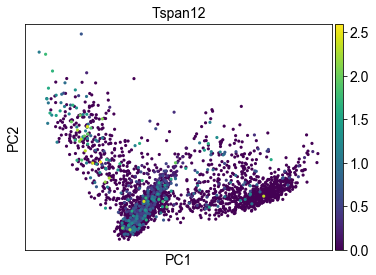

In [28]:
sc.pl.pca(adata, color='Tspan12')

Now let's check how much of the variance information each principal component carries:

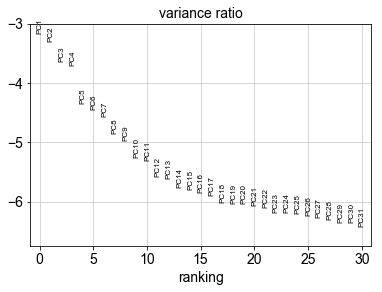

In [29]:
sc.pl.pca_variance_ratio(adata, log=True)

As we can observe from the above plot first 4 pcs carries 

## Computing the neighborhood graph

Here ompute the neighborhood graph of cells using the PCA representation of the data matrix. Since from the above
variance plot we can observe that the first 4 pcs are contributing three orders of magnitude more than the last 4 pcs. I don't have the guidance here so I will accept contributions as low as two order of magnitudes less and cut the pcs at 10. And I will set the nearest neighbour interaction to more long range than from the one in the example case ans set it to 100 (which is the maximum it is suggested in the paper):  

In [78]:
sc.pp.neighbors(adata, n_neighbors=50, n_pcs=50)
sc.tl.louvain(adata)

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished (0:00:00.57) --> added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.62) --> found 10 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)


In [67]:
sc.tl.umap(adata)

computing UMAP
    using 'X_pca' with n_pcs = 10
    finished (0:00:10.62) --> added
    'X_umap', UMAP coordinates (adata.obsm)


In [68]:
adata.var['highly_variable'].head(3)

Tspan12    True
Tshz1      True
Fnbp1l     True
Name: highly_variable, dtype: bool

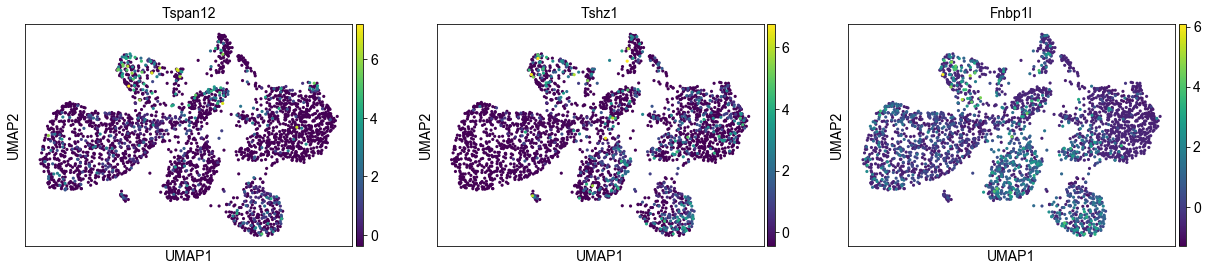

In [69]:
sc.pl.umap(adata, color=['Tspan12', 'Tshz1','Fnbp1l'], use_raw=False)

In [71]:
results_file = './write/aerts_1st_task.h5ad'

Now I want to see if the louvain clustering and cell type clustering matches:

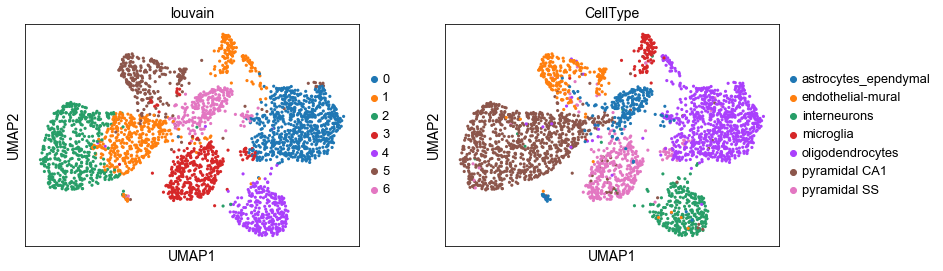

In [72]:
sc.pl.umap(adata, color=['louvain', 'CellType'])

In [ ]:
adata.write(results_file)

In [ ]:
sc.tl.rank_genes_groups(adata, 'louvain', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [ ]:
sc.settings.verbosity = 2  # reduce the verbosity

In [ ]:
sc.tl.rank_genes_groups(adata, 'louvain', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [ ]:
adata.write(results_file)

In [ ]:
sc.tl.rank_genes_groups(adata, 'louvain', method='logreg')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [ ]:
adata = sc.read(results_file)

In [ ]:
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(11)

In [ ]:
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals']}).head(5)

In [ ]:
sc.tl.rank_genes_groups(adata, 'louvain', groups=['0'], reference='1', method='wilcoxon')
sc.pl.rank_genes_groups(adata, groups=['0'], n_genes=20)

In [ ]:
sc.pl.rank_genes_groups_violin(adata, groups='0', n_genes=7)

In [ ]:
adata = sc.read(results_file)

In [ ]:
sc.pl.rank_genes_groups_violin(adata, groups='0', n_genes=7)

In [ ]:
sc.pl.violin(adata, ['Ugt8a', 'Plp1', 'Mbp','Cnp','Mobp','Mag','Mog'], groupby='louvain')

In [ ]:
adata

In [ ]:
marker_genes=['Ugt8a', 'Plp1', 'Mbp','Cnp','Mobp','Mag','Mog'] #are they?

In [ ]:
ax = sc.pl.dotplot(adata, marker_genes, groupby='louvain')

In [ ]:
adata.write_loom(filename="write/aerts_task_unfiltered_hv.loom", write_obsm_varm=True) #highlyyy_variable gene analysis eklendi

In [ ]:
!ls write

In [ ]:
ds = loompy.connect("write/aerts_task_unfiltered_hv.loom",validate=False)
ds.ca.keys()

## To test if I see the same results as t-sne graph of three selected in genes as in scope

In [ ]:
sc.tl.tsne(adata)

In [ ]:
sc.pl.tsne(adata, color='louvain')

In [ ]:
adata.write_loom(filename="write/aerts_task_unfiltered_hv.loom", write_obsm_varm=True) #highlyyy_variable gene analysis eklendi